# project 2

## set up

### step 0

In [12]:
# step 0
# I use macbook. I have created a folder for this project, then I create a virtal environment for 
# the python code.
# If you also use Macbook, here is the command I have used
# cd /path/to/your_project
# python3 -m venv .venv
# source .venv/bin/activate

### step 1

In [ ]:
# step 1: upgrade pip, skip this step if you already upgraded pip
# pip install --upgrade pip

### step 2

In [ ]:
# step 2: install relevant packages, kip this step if you already have insatlled them
# !pip install numpy
# !pip install scikit-learn
# !pip install matplotlib
# !pip install scikit-image

## my solution

### import packages

In [31]:
# import the relevant packages
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color 
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [33]:
# global variables which is speicfied in the task description
n0 = 28 # input dimention
n1 = 64 # hidden layer 1
n2 = 32 # hidden layer 2
n3 = 3  # output dimention

### load data

In [ ]:
# 1. Load MNIST digits
digits = load_digits()
X = digits.data               # shape: (543, 64)
y = digits.target             # shape: (543,)

# 2. Filter classes (1,5,7)
# if the entity in y is 1, 5, or y, then the value true will be stored
# in the mask.
# otherwise, it will store False.
mask = np.isin(y, [1, 5, 7])
X = X[mask]
y = y[mask]

# map labels to {0,1,2}
# label_map is an dictionary,
# previously, the entity in the y represents classes, its value is 0,1,...9
# we only concern about classes 1,5,7,
# therefore, we do mapping on them
label_map = {1:0, 5:1, 7:2}
y = np.array([label_map[v] for v in y])

# 3. Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 4. Standardize
# standardize formular: z = (x - u)/sigma
# u: mean, sigma:
# here, scaler is an empty object, it has no idea about
# how data looks like
scaler = StandardScaler()
# fit_transform does 2 tasks:
# 1) fit: calculate the mean u and std sigma of each colum
# 2) transform: apply the standardize formular(z = (x - u)/sigma)
# on each element of the matrix
X_train = scaler.fit_transform(X_train)

# here, we should only use transform, because the test data set can not
# use its own mean and std, it should use the u and sigma of the training
# data set
X_test = scaler.transform(X_test)

### utility functions

In [39]:
# the task description:
# one_hot encoding, mit Ausgabe eines Binären 3-dimensionalen Arrays,
# wie habe y samples, K categories
# each row means to which category does the sample belong to
def one_hot(y, K=3):
    N = len(y)
    Y = np.zeros((N, K))
    Y[np.arange(N), y] = 1
    return Y

def test_one_hot():
    # Test
    # the example below shows how is the input and output 
    # when you use one_hot function
    y = np.array([2,1,0,2])
    Y = np.zeros((4,3))
    print(Y)
    result = one_hot(y)
    print(result)
    """     [[0. 0. 0.]
            [0. 0. 0.]
            [0. 0. 0.]
            [0. 0. 0.]]

            [[0. 0. 1.]
            [0. 1. 0.]
            [1. 0. 0.]
            [0. 0. 1.]]
    """

In [40]:
# how I got this formula, 
# please read the softplus function herleiten.jpg, that is my note
def softplus(x):
    return np.log1p(np.exp(-np.abs(x))) + np.maximum(x, 0)

# derivative of log(1+exp(x)) = derivative(1+exp(x)) * (1/(1+exp(x)))
def d_softplus(x):
    return 1 / (1 + np.exp(-x))   # sigmoid

In [41]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# concrete steps of proof/calculating
# please read the derivative of sigmoid herleiten.jpg. that is my note
def d_sigmoid(x):
    s = sigmoid(x)
    return s * (1 - s)

### build up multilayer perceptron (MLP)

In [ ]:
def forward():
    pass

In [20]:
import numpy as np

def softplus(x):
    return np.log1p(np.exp(-np.abs(x))) + np.maximum(x, 0)

def d_softplus(x):
    return 1.0 / (1.0 + np.exp(-x))   # = sigmoid(x)

class MLP:
    def __init__(self, D, n1=64, n2=32, K=3, seed=0):
        rng = np.random.default_rng(seed)

        self.W1 = rng.normal(0, 0.01, (D, n1))
        self.b1 = np.zeros((1, n1))

        self.W2 = rng.normal(0, 0.01, (n1, n2))
        self.b2 = np.zeros((1, n2))

        self.W3 = rng.normal(0, 0.01, (n2, K))
        self.b3 = np.zeros((1, K))

    def forward(self, X):
        self.X  = X
        self.z1 = X @ self.W1 + self.b1
        self.a1 = softplus(self.z1)

        self.z2 = self.a1 @ self.W2 + self.b2
        self.a2 = softplus(self.z2)

        self.z3 = self.a2 @ self.W3 + self.b3
        return self.z3            # logits

    def backward(self, grad_out):
        dW3 = self.a2.T @ grad_out
        db3 = np.sum(grad_out, axis=0, keepdims=True)

        da2 = grad_out @ self.W3.T
        dz2 = da2 * d_softplus(self.z2)

        dW2 = self.a1.T @ dz2
        db2 = np.sum(dz2, axis=0, keepdims=True)

        da1 = dz2 @ self.W2.T
        dz1 = da1 * d_softplus(self.z1)

        dW1 = self.X.T @ dz1
        db1 = np.sum(dz1, axis=0, keepdims=True)

        return dW1, db1, dW2, db2, dW3, db3

    def update(self, grads, lr=0.01):
        dW1, db1, dW2, db2, dW3, db3 = grads

        self.W1 -= lr * dW1
        self.b1 -= lr * db1
        self.W2 -= lr * dW2
        self.b2 -= lr * db2
        self.W3 -= lr * dW3
        self.b3 -= lr * db3


In [21]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import numpy as np

# 1. Load data
digits = load_digits()
X = digits.data
y = digits.target

mask = np.isin(y, [1,5,7])
X = X[mask]
y = y[mask]

label_map = {1:0, 5:1, 7:2}
y = np.array([label_map[v] for v in y])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# one-hot
def one_hot(y, K=3):
    N = len(y)
    Y = np.zeros((N, K))
    Y[np.arange(N), y] = 1
    return Y

def softmax(z):
    z = z - np.max(z, axis=1, keepdims=True)
    expz = np.exp(z)
    return expz / np.sum(expz, axis=1, keepdims=True)

def cross_entropy_loss(logits, Y):
    P = softmax(logits)
    loss = -np.sum(Y * np.log(P + 1e-9)) / len(Y)
    grad = (P - Y) / len(Y)    # dL/dz3
    return loss, grad

# 2. 初始化模型
D = X_train.shape[1]
model = MLP(D=D, n1=64, n2=32, K=3)

Y_train = one_hot(y_train)
Y_test  = one_hot(y_test)

# 3. 训练循环（full batch）
epochs = 50
lr = 0.01

for ep in range(epochs):
    logits = model.forward(X_train)
    loss, grad_out = cross_entropy_loss(logits, Y_train)

    grads = model.backward(grad_out)
    model.update(grads, lr=lr)

    # evaluate
    test_logits = model.forward(X_test)
    test_pred = np.argmax(test_logits, axis=1)
    acc = accuracy_score(y_test, test_pred)

    print(f"epoch {ep:03d} | loss={loss:.4f} | test_acc={acc:.3f}")


epoch 000 | loss=1.0987 | test_acc=0.330
epoch 001 | loss=1.0987 | test_acc=0.330
epoch 002 | loss=1.0987 | test_acc=0.330
epoch 003 | loss=1.0987 | test_acc=0.330
epoch 004 | loss=1.0987 | test_acc=0.330
epoch 005 | loss=1.0987 | test_acc=0.330
epoch 006 | loss=1.0986 | test_acc=0.330
epoch 007 | loss=1.0986 | test_acc=0.330
epoch 008 | loss=1.0986 | test_acc=0.330
epoch 009 | loss=1.0986 | test_acc=0.330
epoch 010 | loss=1.0986 | test_acc=0.330
epoch 011 | loss=1.0986 | test_acc=0.330
epoch 012 | loss=1.0986 | test_acc=0.330
epoch 013 | loss=1.0986 | test_acc=0.330
epoch 014 | loss=1.0986 | test_acc=0.330
epoch 015 | loss=1.0986 | test_acc=0.330
epoch 016 | loss=1.0986 | test_acc=0.330
epoch 017 | loss=1.0986 | test_acc=0.330
epoch 018 | loss=1.0986 | test_acc=0.330
epoch 019 | loss=1.0986 | test_acc=0.330
epoch 020 | loss=1.0986 | test_acc=0.330
epoch 021 | loss=1.0986 | test_acc=0.330
epoch 022 | loss=1.0986 | test_acc=0.330
epoch 023 | loss=1.0986 | test_acc=0.330
epoch 024 | loss

In [27]:
from sklearn.metrics import accuracy_score
import numpy as np

def train_full_batch(model, 
                     X_train, y_train, 
                     X_test, y_test, 
                     loss_fn,      # z.B. cross_entropy_loss
                     epochs=50,
                     lr=0.01):

    Y_train = one_hot(y_train)
    Y_test  = one_hot(y_test)

    train_losses = []
    test_losses  = []
    test_accs    = []

    for ep in range(epochs):

        # ---- Forward ----
        logits = model.forward(X_train)

        # ---- Loss + Grad ----
        train_loss, grad_out = loss_fn(logits, Y_train)

        # ---- Backward ----
        grads = model.backward(grad_out)

        # ---- Update ----
        model.update(grads, lr)

        # ---- Evaluate on test ----
        test_logits = model.forward(X_test)
        test_loss, _ = loss_fn(test_logits, Y_test)

        y_pred = np.argmax(test_logits, axis=1)
        acc = accuracy_score(y_test, y_pred)

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        test_accs.append(acc)

        print(f"Epoch {ep:03d} | "
              f"Train Loss={train_loss:.4f} | "
              f"Test Loss={test_loss:.4f} | "
              f"Test Acc={acc:.3f}")

    return train_losses, test_losses, test_accs


In [28]:
import matplotlib.pyplot as plt

def plot_loss(train_losses, test_losses):
    plt.figure(figsize=(7,5))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(test_losses, label="Test Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss über die Epochen")
    plt.legend()
    plt.grid(True)
    plt.show()


In [29]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix_matplotlib(model, X_test, y_test,
                                     class_names=None):
    """
    Zeichnet die Confusion-Matrix nur mit matplotlib.
    class_names: Liste wie ["1","5","7"] oder ["0","1","2"]
    """
    # Vorhersage
    logits = model.forward(X_test)
    y_pred = np.argmax(logits, axis=1)

    # Confusion-Matrix berechnen
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(5,4))
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()

    # Achsen-Beschriftung
    if class_names is None:
        classes = np.arange(cm.shape[0])
    else:
        classes = class_names

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    plt.xlabel("Predicted label")
    plt.ylabel("True label")

    # Zahlen in die Kästchen schreiben
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, str(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.show()


Epoch 000 | Train Loss=1.0986 | Test Loss=1.0986 | Test Acc=0.330
Epoch 001 | Train Loss=1.0986 | Test Loss=1.0986 | Test Acc=0.330
Epoch 002 | Train Loss=1.0986 | Test Loss=1.0986 | Test Acc=0.330
Epoch 003 | Train Loss=1.0986 | Test Loss=1.0986 | Test Acc=0.330
Epoch 004 | Train Loss=1.0986 | Test Loss=1.0986 | Test Acc=0.330
Epoch 005 | Train Loss=1.0986 | Test Loss=1.0986 | Test Acc=0.330
Epoch 006 | Train Loss=1.0986 | Test Loss=1.0986 | Test Acc=0.330
Epoch 007 | Train Loss=1.0986 | Test Loss=1.0986 | Test Acc=0.330
Epoch 008 | Train Loss=1.0986 | Test Loss=1.0986 | Test Acc=0.330
Epoch 009 | Train Loss=1.0986 | Test Loss=1.0986 | Test Acc=0.330
Epoch 010 | Train Loss=1.0986 | Test Loss=1.0986 | Test Acc=0.330
Epoch 011 | Train Loss=1.0986 | Test Loss=1.0986 | Test Acc=0.330
Epoch 012 | Train Loss=1.0986 | Test Loss=1.0986 | Test Acc=0.330
Epoch 013 | Train Loss=1.0986 | Test Loss=1.0986 | Test Acc=0.330
Epoch 014 | Train Loss=1.0986 | Test Loss=1.0986 | Test Acc=0.330
Epoch 015 

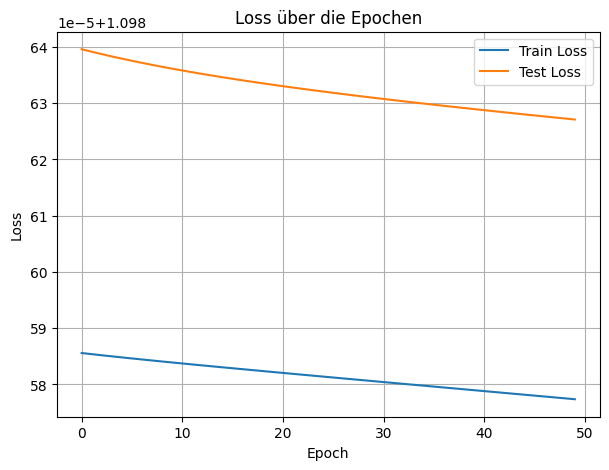

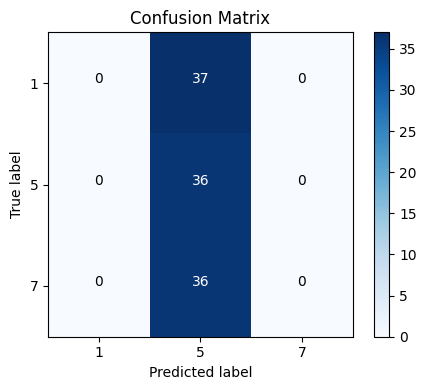

In [30]:
# 训练
train_losses, test_losses, test_accs = train_full_batch(
    model,
    X_train, y_train,
    X_test, y_test,
    loss_fn=cross_entropy_loss,
    epochs=50,
    lr=0.01
)

# 绘制 Loss 曲线
plot_loss(train_losses, test_losses)

# 绘制 Confusion-Matrix
plot_confusion_matrix_matplotlib(model, X_test, y_test,
                                 class_names=["1", "5", "7"])
